# creates 51_..._.csv out of the foreground anndata while using leiden and marking the clusters

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

fg = sc.read_h5ad("../data/pyED_correct.h5ad")
fg

hvg_bool = True

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Keep Gene Expression features if available
ft = "Type" if "Type" in fg.var.columns else None
if ft: fg = fg[:, fg.var[ft] == "Gene Expression"].copy()


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


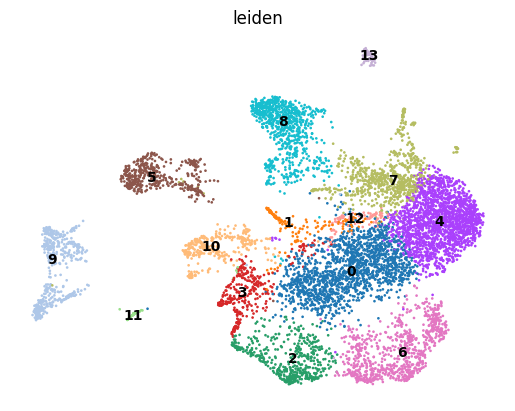

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [3]:
# avoid DE issues
sc.pp.filter_genes(fg, min_counts=1)

#  preprocessing pipeline 
sc.pp.normalize_total(fg, target_sum=1e4)
sc.pp.log1p(fg)
if hvg_bool:
    sc.pp.highly_variable_genes(fg, n_top_genes=2000, flavor="seurat")
    fg = fg[:, fg.var["highly_variable"]].copy()
sc.pp.scale(fg, max_value=10)
sc.tl.pca(fg, n_comps=30, svd_solver="arpack")
sc.pp.neighbors(fg, n_neighbors=20, n_pcs=30)
sc.tl.leiden(fg, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

sc.tl.umap(fg, min_dist=0.3, spread=1.0, random_state=42)
if hvg_bool:
    sc.pl.umap(fg, color=["leiden"], legend_loc="on data", frameon=False, show=True, save="_leiden_HVG.png")
else:
    sc.pl.umap(fg, color=["leiden"], legend_loc="on data", frameon=False, show=True, save="_leiden.png")

sc.tl.rank_genes_groups(fg, "leiden", method="wilcoxon")

In [4]:
sc.tl.rank_genes_groups(fg, groupby="leiden", method="wilcoxon", use_raw=False)
if hvg_bool:
    sc.pl.rank_genes_groups(fg, n_genes=25, sharey=False, show=False, save="_top25_HVG.png")
else:
    sc.pl.rank_genes_groups(fg, n_genes=25, sharey=False, show=False, save="_top25.png")

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [5]:
# print gene that is appearing the most in the fg data
print(fg.var_names[fg.X.sum(axis=0).argmax()])

MGP


In [6]:
# Map clusters to cell types by marker scores (edit markers as needed)
# load json file
import json
with open('02_mapped_gene_markers/exclusive_gene_markers.json', 'r') as f:
    marker_sets = json.load(f)

print(marker_sets.keys())
print(marker_sets["Later Stids"])

## Use symbols if present; fallback to IDs
#if "Symbol" in fg.var.columns:
#    sym = fg.var["Symbol"].astype(str).values
#    sym[ (sym=="") | pd.isna(sym) ] = fg.var_names[(sym=="") | pd.isna(sym)]
#    fg.var_names = sym
#    fg.var_names_make_unique()

dict_keys(['Early Sgonia', 'Late Sgonia', 'Early Scytes', 'Late Scytes', 'Round Stids', 'Later Stids', 'Sertoli', 'Leydig'])
['SUFU', 'DLL1', '1700024P04RIK', 'PRM1', 'DYRK4', 'TNP1', 'HSPA1L']


In [7]:
# Cluster-level assignment by mean marker expression
ct = pd.Series(index=fg.obs_names, data="unknown")

print("taking all ", len(fg.obs_names), " cells into account")
print("iterating over all ", len(fg.obs["leiden"].cat.categories), " leiden clusters")
print("foreground has the shape: ", fg.shape)

# iterate over all values of the marker_sets and check if they are in the foreground
for key, genes in marker_sets.items():
    if any(gene in fg.var_names for gene in genes):
        print(f"Of {key} any gene was found in the foreground")
    else:
        print(f"{key} is not in the foreground")

taking all  8202  cells into account
iterating over all  14  leiden clusters
foreground has the shape:  (8202, 2000)
Of Early Sgonia any gene was found in the foreground
Of Late Sgonia any gene was found in the foreground
Early Scytes is not in the foreground
Late Scytes is not in the foreground
Of Round Stids any gene was found in the foreground
Of Later Stids any gene was found in the foreground
Sertoli is not in the foreground
Of Leydig any gene was found in the foreground


In [8]:
for cl in fg.obs["leiden"].cat.categories:
    cells = fg.obs_names[fg.obs["leiden"] == cl]
    if len(cells) == 0: 
        continue
    scores = {}

    # iterating over all items in the dict(keys and genes)
    for key, genes in marker_sets.items():    
        g = [g for g in genes if g in fg.var_names]

        if len(g) == 0: 
            scores[key] = -np.inf
        
        else:
            scores[key] = float(fg[cells, g].X.mean())
    
    best = max(scores, key=scores.get)
    
    ct.loc[cells] = best

fg.obs["cluster_type"] = ct.astype("category")

Problem: with hvg set at 2000 we cant find any genes out of our exclusive gene list to map/match. so none of these exclusive genes is even in the top 2000 hvg genes of our pyED foreground. 
## fixed by using .upper() when saving the marker gene json since i couldnt find "Prm1" in var_names of our pyED foreground since all gene names are in capital there.

In [9]:
# Save labels for decontX
out = fg.obs[["cluster_type"]].copy()
if hvg_bool:
    out.to_csv("03_mapped_clusters/pyED_cluster_celltype_HVG.csv")
else:
    out.to_csv("03_mapped_clusters/pyED_cluster_celltype.csv")